In [1]:
import os
import functools
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from huggingface_hub import hf_hub_download
from PIL import Image, ImageShow
import PIL
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from diffusers.utils import make_image_grid
from IPython.core.debugger import Pdb
from einops import rearrange
import cv2
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import numpy as np
import pprint
import runpy
import sys
from src.models.attention_processor import SkipAttnProcessor
from src.pipelines.spacat_pipeline import TryOnPipeline
from src.dataset.vitonhd import VITONHDDataset
from src.dataset.dresscode import DressCodeDataset
from src.utils import get_project_root, show, init_attn_processor
from src.preprocess.humanparsing.run_parsing import Parsing
from src.preprocess.openpose.run_openpose import OpenPose
from src.utils.mask import get_mask_location
from src.preprocess import apply_net
from src.utils import get_project_root, mask2agn
from src.utils.mask_v2 import Maskerv2 as Masker 

In [2]:
# h, w = (512, 384)
h, w = (1024, 768)

In [3]:
def merge(
    img1: PIL.Image.Image,
    img2: PIL.Image.Image
) -> PIL.Image.Image:
    assert img1.size[1] == img2.size[1]
    h, w = img1.size[1], img1.size[0]
    w2 = img2.size[0]
    img = Image.new('RGB', (w + w2, h))
    img.paste(img1, (0, 0))
    img.paste(img2, (w, 0))
    return img

In [4]:
def apply_poisson_blending(
    original_img: PIL.Image.Image,
    tryon_img: PIL.Image.Image,
    mask_img: PIL.Image.Image
) -> PIL.Image.Image:
    w, h = original_img.size
    original_img = np.array(original_img)
    tryon_img = np.array(tryon_img)
    mask_img = np.array(mask_img)
    mask_img = 255 - mask_img
    output = cv2.seamlessClone(original_img, tryon_img, mask_img, (w//2, h//2), cv2.NORMAL_CLONE)
    return Image.fromarray(output, mode='RGB')

In [5]:
""" Download models from Huggingface Hub
"""
PROJECT_ROOT_PATH = get_project_root()
repo_id = 'bui/Navier-1'
model_name = 'navier-1-beta-1512-1024x768'
ckpt_name = 'ckpt-108000[216k-steps][bs32]'
base_folder = os.path.join(model_name, ckpt_name)

# unet
unet_path = hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'unet'),
    filename='diffusion_pytorch_model.safetensors',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'unet'),
    filename='config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)

# vae
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'vae'),
    filename='diffusion_pytorch_model.safetensors',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'vae'),
    filename='config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
# scheduler
hf_hub_download(
    repo_id=repo_id,
    subfolder=os.path.join(base_folder, 'scheduler'),
    filename='scheduler_config.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)
# model_index.json
hf_hub_download(
    repo_id=repo_id,
    subfolder=base_folder,
    filename='model_index.json',
    local_dir=os.path.join(PROJECT_ROOT_PATH, 'checkpoints', 'navier-1')
)

model_root_path = os.path.dirname(os.path.dirname(unet_path))
model_root_path

'/home/jupyter/H-engine/checkpoints/navier-1/navier-1-beta-1512/ckpt-132000'

In [6]:
vae = AutoencoderKL.from_pretrained(
    model_root_path,
    subfolder='vae',
    torch_dtype=torch.float16
)
scheduler = DDPMScheduler.from_pretrained(
    model_root_path,
    subfolder='scheduler'
)

unet = UNet2DConditionModel.from_pretrained(
    model_root_path,
    subfolder='unet',
    torch_dtype=torch.float16
)
init_attn_processor(unet, cross_attn_cls=SkipAttnProcessor)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
gpu_id = 0
human_parser = Parsing(gpu_id)
openpose = OpenPose(gpu_id)
masker = Masker()

2025-01-15 06:27:38.890140767 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory

2025-01-15 06:27:38.890178901 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.
2025-01-15 06:27:39.562585847 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_

In [8]:
vitonhd = VITONHDDataset(
    data_rootpath=os.path.join(PROJECT_ROOT_PATH, 'datasets', 'vitonhd'),
    use_trainset=False,
    height=h,
    width=w,
    use_CLIPVision=True,
    use_dilated_relaxed_mask=True
)

dresscode = DressCodeDataset(
    data_rootpath='/hosjiu/data/DressCode/',
    phase='test',
    h=h,
    w=w,
    use_dilated_relaxed_mask=True
)

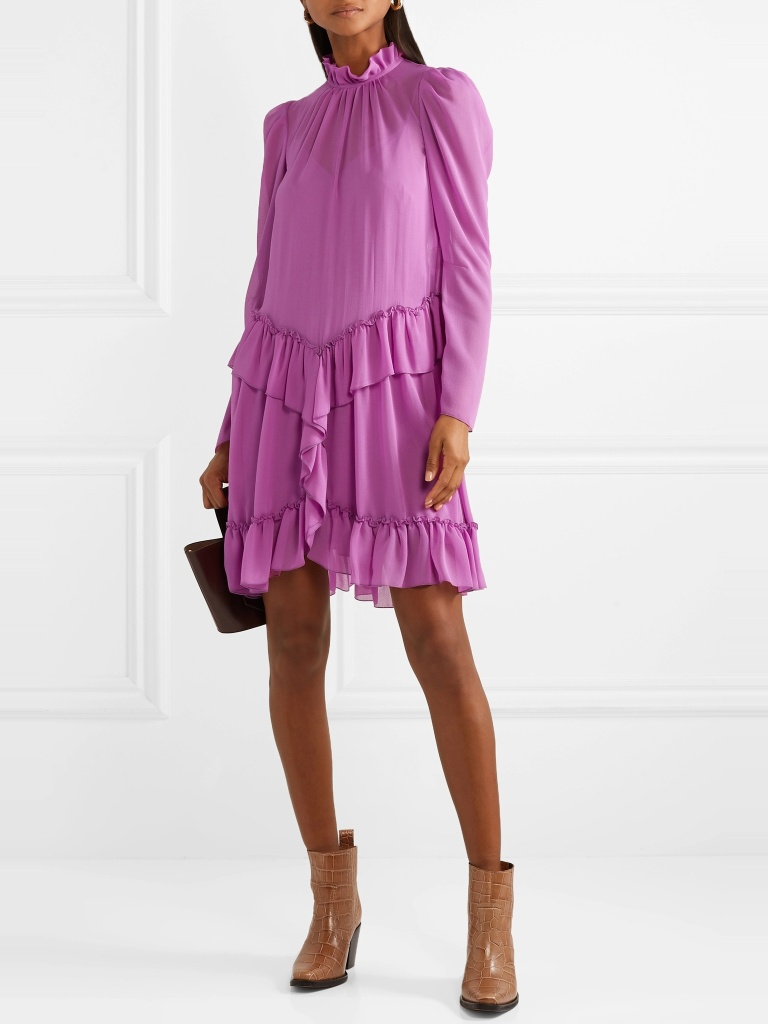

In [9]:
# img_path = testset[14]['original_image_path']
# img_path = '../assets/man1_good.jpg'
# img = Image.open(img_path)
# img = PIL.ImageOps.cover(img, (w, h))
category = 'dresses'
img_path = f'/hosjiu/data/DressCode/{category}/images/052005_0.jpg'
img = Image.open(img_path)
img = PIL.ImageOps.fit(img, size=(w, h))
img

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


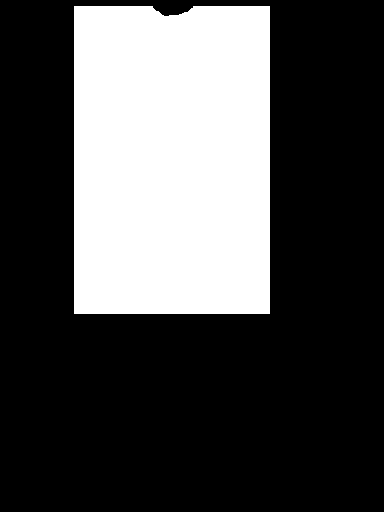

In [25]:
mask1 = False

if mask1:
    keypoints, _ = openpose(img)
    body_parse, _  = human_parser(img)
    mask_img, _, _, _ = get_mask_location(
        model_type='hd',
        category='upper_body',
        model_parse=body_parse,
        keypoint=keypoints,
        width=w,
        height=h
    )
else:
    mask_img = masker.create_mask(img.resize((384, 512)), 'dresses')

mask_img

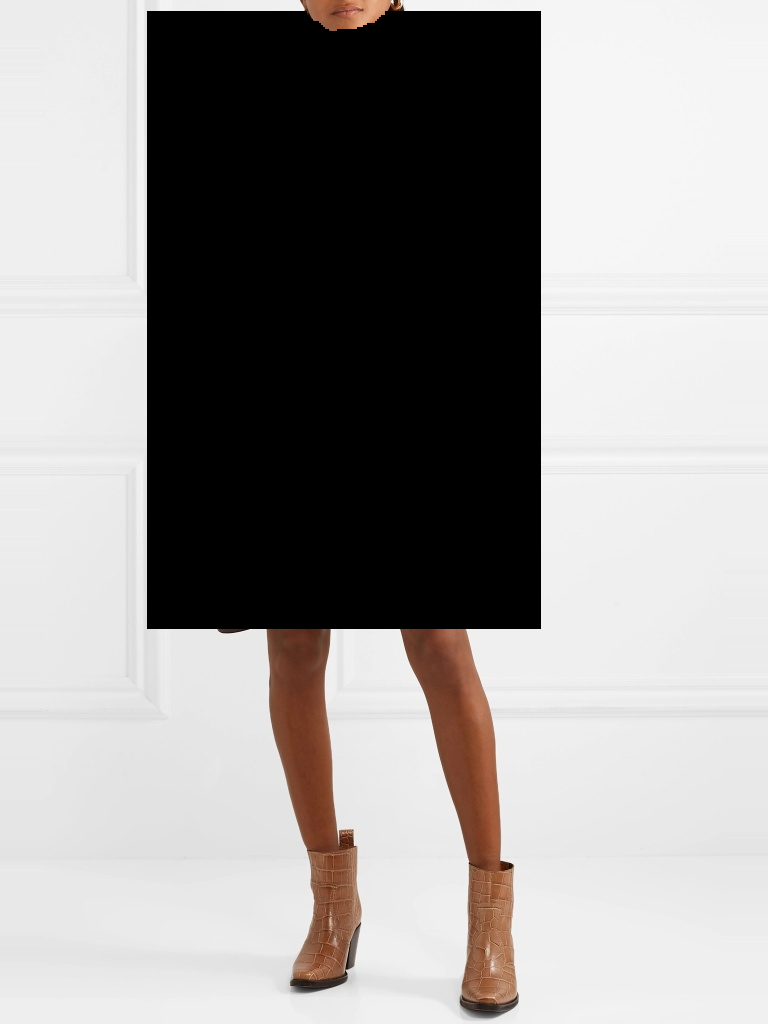

In [26]:
mask_arr = np.array(mask_img.resize((w, h)))
mask_arr = np.stack([mask_arr] * 3)
mask_arr = rearrange(mask_arr, 'c h w -> h w c')
masked_img = np.where(mask_arr, np.array(img) * 0, np.array(img))
masked_img = Image.fromarray(masked_img)
masked_img

In [ ]:
args = apply_net.create_argument_parser().parse_args((
    'show',
    '../configs/densepose_rcnn_R_50_FPN_s1x.yaml',
    '../checkpoints/densepose/model_final_162be9.pkl',
    img_path,
    'dp_segm',
    '-v'
))
densepose_np, instances, matrix_vis, mask_bg, _ = args.func(args, img)
dense = Image.fromarray(densepose_np[:, :, ::-1])
dense

In [ ]:
outfit_path = f'/hosjiu/data/DressCode/upper_body/images/000248_1.jpg'
# outfit_path = '../datasets/vitonhd/test/cloth/00008_00.jpg'
outfit = Image.open(outfit_path).resize((w, h))
outfit

In [ ]:
mask = pil_to_tensor(mask_img).unsqueeze(0)
densepose = torch.from_numpy(densepose_np).permute(2, 0, 1).unsqueeze(0)
# cloth = testset[idx]['cloth_raw'].unsqueeze(0)
cloth = VITONHDDataset.preprocess(outfit, w, h).unsqueeze(0)
image = VITONHDDataset.preprocess(img, w, h).unsqueeze(0)

print(f'mask: {mask.shape}')
print(f'densepose: {densepose.shape}')
print(f'cloth: {cloth.shape}')
print(f'img: {image.shape}')

In [ ]:
pipe = TryOnPipeline(
    unet=unet,
    vae=vae,
    scheduler=scheduler
).to(device)

with torch.inference_mode():
    with torch.amp.autocast(device):
        images = pipe(
            image=image.to(device),
            mask_image=mask.to(device),
            densepose_image=densepose.to(device),
            cloth_image=cloth.to(device),
            height=h,
            width=w,
            generator=torch.manual_seed(1996),
            guidance_scale=1.3,
        ).images

del pipe
torch.cuda.empty_cache()

In [ ]:
poisson = apply_poisson_blending(img, images[0], mask_img)
poisson

In [ ]:
# save_path = os.path.join(PROJECT_ROOT_PATH, 'results', 'navier-1', 'beta', 'final', 'in_the_wilds')
# os.makedirs(save_path, exist_ok=True)
# img_name = img_path.split('.')[-2].split('/')[-1]

# fname = f'{img_name}-{idx}.png'
# images[0].save(Path(save_path, fname))

# fname = f'{img_name}-{idx}-poisson.png'
# poisson.save(Path(save_path, fname))

In [ ]:
# original_image = Image.open('../assets/man10.jpg').resize((w, h))
# tryon_img = Image.open('../results/navier-1/beta/final/in_the_wilds/man10-7-poisson.png').resize((w, h))
# original_cloth = Image.open(testset[7]['original_cloth_path']).resize((w, h))

out = functools.reduce(merge, [poisson, mask2agn(np.array(mask_img), img), img, outfit])
# fname = 'merged-man10-7-poisson.png'
# out.save(Path(save_path, fname))
# out.save(f'../results/test/navier-1-beta-1512_{ckpt_name}.png')
out